In [1]:
import numpy as np
import os
import scipy.io as sio
import cv2
import math
from math import cos, sin
# import dlib
import glob
from pathlib import Path
import pandas as pd
from PIL import Image, ImageFilter
import matplotlib.pyplot as plt
import joblib
import mediapipe as mp
from sklearn.preprocessing import FunctionTransformer
from sklearn.base import BaseEstimator, TransformerMixin



In [2]:
from sklearn.model_selection import train_test_split
from numpy import mean
from numpy import std
from numpy import absolute
# from sklearn.datasets import make_regression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.multioutput import MultiOutputRegressor
# from sklearn.svm import SVR
# from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
import imutils
from mediapipe.python.solutions.drawing_utils import _normalized_to_pixel_coordinates



# Creating Data Frame from images and matfiles

In [3]:
mp_face_mesh = mp.solutions.face_mesh


face_mesh_images = mp_face_mesh.FaceMesh(static_image_mode=False, max_num_faces=1,
                                         min_detection_confidence=.1)

mp_drawing = mp.solutions.drawing_utils

mp_drawing_styles = mp.solutions.drawing_styles


In [4]:
imgs = glob.glob("./AFLW2000/*.jpg", 
                   recursive = True)
imgs[:5]
print(len(imgs))

2000


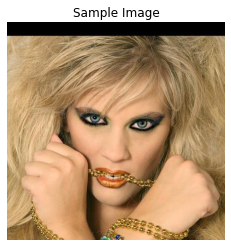

x: 0.4827955365180969
y: 0.6890772581100464
z: -0.017872530966997147

In [5]:
img = cv2.imread(imgs[0])
plt.title("Sample Image");plt.axis('off');plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB));plt.show()
face_mesh_results = face_mesh_images.process(img[:,:,::-1])
face_mesh_results.multi_face_landmarks[0].landmark[0]

In [6]:
mp_face = mp.solutions.face_detection.FaceDetection(
    model_selection=1, # model selection
    min_detection_confidence=0.2# confidence threshold
)


In [7]:
def crop_faces(dframe):
    image_rows, image_cols, _ = dframe.shape
    image_input = cv2.cvtColor(dframe, cv2.COLOR_BGR2RGB)
    results = mp_face.process(image_input)
    if results.detections:
        detection=results.detections[0]
        location = detection.location_data

        relative_bounding_box = location.relative_bounding_box
        rect_start_point = _normalized_to_pixel_coordinates(
            relative_bounding_box.xmin, relative_bounding_box.ymin, image_cols,
            image_rows)
        rect_end_point = _normalized_to_pixel_coordinates(
            relative_bounding_box.xmin + relative_bounding_box.width,
            relative_bounding_box.ymin + relative_bounding_box.height, image_cols,
            image_rows)



        if(rect_end_point !=None and rect_start_point != None  ):
            xleft,ytop=rect_start_point
            xright,ybot=rect_end_point

            crop_img = image_input[ytop: ybot, xleft: xright]
            return crop_img
        
    return image_input

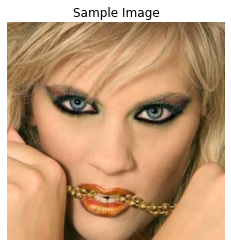

In [8]:
img_2 = crop_faces(img)
img_2 = cv2.resize(img_2, (300,300), interpolation = cv2.INTER_AREA)

plt.title("Sample Image");plt.axis('off');plt.imshow(img_2);plt.show()


## Extract land marks from crop faces

In [10]:
landmarks_faces = []
faces_not_detected_path = [] 
# i = 1
for img_path in imgs: 
#     print(i)
    img = cv2.imread(img_path)
    img = crop_faces(img)
    img = cv2.resize(img, (300,300), interpolation = cv2.INTER_AREA)
    face_mesh_results = face_mesh_images.process(img[:,:,::-1])
    if face_mesh_results.multi_face_landmarks:

        landmarks_x = [face_mesh_results.multi_face_landmarks[0].landmark[i].x for i in range(468)]
        landmarks_y = [face_mesh_results.multi_face_landmarks[0].landmark[i].y for i in range(468)]
        landmarks = landmarks_x + landmarks_y
        landmarks_faces.append(landmarks) 
        
    else :
        faces_not_detected_path.append(img_path)
#     i+=1
    


In [11]:
landmarks_faces  = pd.DataFrame((np.array(landmarks_faces)))
print(faces_not_detected_path[:5])
landmarks_faces


['./AFLW2000/image00002.jpg', './AFLW2000/image00004.jpg', './AFLW2000/image00010.jpg', './AFLW2000/image00032.jpg', './AFLW2000/image00036.jpg']


,0,1,2,3,4,5,6,7,8,9,...,926,927,928,929,930,931,932,933,934,935
0,0.506746,0.524598,0.513260,0.488361,0.525895,0.523963,0.515261,0.241516,0.511658,0.511501,...,0.561701,0.550563,0.561972,0.565848,0.570358,0.334771,0.345668,0.353973,0.316554,0.303236
1,0.556080,0.493270,0.527290,0.439235,0.478445,0.467455,0.450319,0.251197,0.423443,0.405138,...,0.699973,0.684434,0.667075,0.707814,0.707518,0.407483,0.425445,0.441679,0.331760,0.308632
2,0.551459,0.514825,0.530018,0.459994,0.505228,0.495308,0.474527,0.233168,0.457046,0.445311,...,0.557162,0.540601,0.556273,0.562561,0.570470,0.307344,0.321624,0.330388,0.248034,0.234612
3,0.488514,0.464211,0.482307,0.438516,0.461732,0.465847,0.480033,0.224051,0.484145,0.483179,...,0.504405,0.488772,0.530688,0.507145,0.520491,0.278143,0.287404,0.291194,0.244245,0.226639
4,0.499136,0.500899,0.500405,0.471392,0.501863,0.503503,0.506988,0.226320,0.510949,0.513219,...,0.482854,0.468589,0.513536,0.484967,0.498848,0.268473,0.274868,0.276422,0.258732,0.245205
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1534,0.339222,0.259604,0.341991,0.279990,0.249435,0.266919,0.332127,0.307331,0.335504,0.319738,...,0.594397,0.579765,0.600988,0.598099,0.607362,0.339836,0.358958,0.372323,0.281861,0.253489
1535,0.538685,0.590662,0.546010,0.538684,0.596947,0.588496,0.550606,0.210670,0.540895,0.544158,...,0.663950,0.647442,0.650523,0.670969,0.673656,0.373328,0.390949,0.407098,0.337067,0.312501
1536,0.516293,0.522254,0.512410,0.478922,0.522749,0.518587,0.504411,0.200811,0.496703,0.495936,...,0.637203,0.623740,0.644064,0.641865,0.648535,0.374760,0.387616,0.397155,0.338083,0.322483
1537,0.555813,0.594657,0.562973,0.546665,0.599620,0.593514,0.565966,0.228488,0.560180,0.563883,...,0.665982,0.652156,0.658518,0.671764,0.675323,0.387487,0.401679,0.414028,0.354744,0.337306


In [12]:
image_name = [Path(f).stem for f in faces_not_detected_path]
print(len(image_name))
image_name[:5]


461


['image00002', 'image00004', 'image00010', 'image00032', 'image00036']

## EXtract labels from yaw, pitch, roll from .mat annotation

In [13]:
def get_ypr_from_mat(mat_path):
    # Get yaw, pitch, roll from .mat annotation.
    # They are in radians
    mat = sio.loadmat(mat_path)
    pre_pose_params = mat['Pose_Para'][0]
    pose_params = np.array(pre_pose_params[:3])
    return pose_params

In [14]:
poses_in_radians = []
for mat_path in glob.glob("./AFLW2000/*.mat"):
    if(Path(mat_path).stem  not in image_name):
        
        pose = get_ypr_from_mat(mat_path)        
        poses_in_radians.append(pose)
    
print(np.array(poses_in_radians).shape)

(1539, 3)


In [15]:
poses_in_radians  = pd.DataFrame((np.array(poses_in_radians)),columns = ['pitch', 'yaw', 'roll'])
poses_in_radians

,pitch,yaw,roll
0,-0.184650,0.881137,-0.236852
1,-0.175379,0.299208,-0.373374
2,-0.026812,0.011965,-0.220662
3,0.057119,0.110732,-0.043283
4,0.223228,0.022474,-0.006809
...,...,...,...
1534,0.328823,0.945760,0.161944
1535,0.378447,-0.065071,-0.054410
1536,-0.006980,0.101763,0.031569
1537,0.513304,0.660324,0.073868


In [16]:
df = landmarks_faces.merge(poses_in_radians,right_index=True,left_index = True)
df

,0,1,2,3,4,5,6,7,8,9,...,929,930,931,932,933,934,935,pitch,yaw,roll
0,0.506746,0.524598,0.513260,0.488361,0.525895,0.523963,0.515261,0.241516,0.511658,0.511501,...,0.565848,0.570358,0.334771,0.345668,0.353973,0.316554,0.303236,-0.184650,0.881137,-0.236852
1,0.556080,0.493270,0.527290,0.439235,0.478445,0.467455,0.450319,0.251197,0.423443,0.405138,...,0.707814,0.707518,0.407483,0.425445,0.441679,0.331760,0.308632,-0.175379,0.299208,-0.373374
2,0.551459,0.514825,0.530018,0.459994,0.505228,0.495308,0.474527,0.233168,0.457046,0.445311,...,0.562561,0.570470,0.307344,0.321624,0.330388,0.248034,0.234612,-0.026812,0.011965,-0.220662
3,0.488514,0.464211,0.482307,0.438516,0.461732,0.465847,0.480033,0.224051,0.484145,0.483179,...,0.507145,0.520491,0.278143,0.287404,0.291194,0.244245,0.226639,0.057119,0.110732,-0.043283
4,0.499136,0.500899,0.500405,0.471392,0.501863,0.503503,0.506988,0.226320,0.510949,0.513219,...,0.484967,0.498848,0.268473,0.274868,0.276422,0.258732,0.245205,0.223228,0.022474,-0.006809
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1534,0.339222,0.259604,0.341991,0.279990,0.249435,0.266919,0.332127,0.307331,0.335504,0.319738,...,0.598099,0.607362,0.339836,0.358958,0.372323,0.281861,0.253489,0.328823,0.945760,0.161944
1535,0.538685,0.590662,0.546010,0.538684,0.596947,0.588496,0.550606,0.210670,0.540895,0.544158,...,0.670969,0.673656,0.373328,0.390949,0.407098,0.337067,0.312501,0.378447,-0.065071,-0.054410
1536,0.516293,0.522254,0.512410,0.478922,0.522749,0.518587,0.504411,0.200811,0.496703,0.495936,...,0.641865,0.648535,0.374760,0.387616,0.397155,0.338083,0.322483,-0.006980,0.101763,0.031569
1537,0.555813,0.594657,0.562973,0.546665,0.599620,0.593514,0.565966,0.228488,0.560180,0.563883,...,0.671764,0.675323,0.387487,0.401679,0.414028,0.354744,0.337306,0.513304,0.660324,0.073868


## Preprocss faces 

In [17]:
class noramlize_points(BaseEstimator, TransformerMixin):
    def fit(self, X,y = None):
        return self
    def transform(self, X,y = None):
        
        brow_nose_dist = np.sqrt(((X.iloc[:,296].values - X.iloc[:,1].values) **2) + ((X.iloc[:,792].values - X.iloc[:,470].values) **2))
#         print(brow_nose_dist)
        X = X / brow_nose_dist[:,np.newaxis]
        X.iloc[:,:468] = X.iloc[:,:468].values- X[1].values[:,np.newaxis]
        X.iloc[:,469:] = X.iloc[:,469:].values- X[470].values[:,np.newaxis]
        
        return X

In [18]:
X_train,X_test,y_train,y_test =  train_test_split(df.drop(['pitch', 'yaw', 'roll'],axis = 1),df[['pitch', 'yaw', 'roll']],test_size = .1,random_state=123)

# Traing and validation model 

In [19]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_absolute_error 
from sklearn.metrics import r2_score
from sklearn.model_selection import RepeatedKFold,cross_val_score
from xgboost import XGBRegressor
from sklearn.multioutput import MultiOutputRegressor

model = make_pipeline(
#                          PCA(n_components = 150),
                           MultiOutputRegressor(XGBRegressor(n_estimators=500, max_depth=3, eta=.1, subsample=0.7, colsample_bytree=0.7)))

X_train = noramlize_points().transform(X_train)

model.fit(X_train,y_train)



Pipeline(steps=[('multioutputregressor',
                 MultiOutputRegressor(estimator=XGBRegressor(base_score=None,
                                                             booster=None,
                                                             callbacks=None,
                                                             colsample_bylevel=None,
                                                             colsample_bynode=None,
                                                             colsample_bytree=0.7,
                                                             early_stopping_rounds=None,
                                                             enable_categorical=False,
                                                             eta=0.1,
                                                             eval_metric=None,
                                                             gamma=None,
                                                             gpu_id=None,
     

In [24]:
from sklearn.metrics import r2_score

X_test = noramlize_points().transform(X_test)
y_predicted_test = model.predict(X_test)
print(mean_squared_error(y_test.values, y_predicted_test))

y_predicted_train = model.predict(X_train)
print(mean_squared_error(y_train.values, y_predicted_train))

0.138583468898387
0.006175760816583355


# testing model

## extract face landmark from image

In [25]:
def face_land_marks(image_path):
    img = cv2.imread(image_path)
    img = crop_faces(img)
    img = cv2.resize(img, (300,300), interpolation = cv2.INTER_AREA)
    face_mesh_results = face_mesh_images.process(img[:,:,::-1])
    if face_mesh_results.multi_face_landmarks:
        landmarks_x = [face_mesh_results.multi_face_landmarks[0].landmark[i].x for i in range(468)]
        landmarks_y = [face_mesh_results.multi_face_landmarks[0].landmark[i].y for i in range(468)]
        landmarks = landmarks_x + landmarks_y
    return landmarks


### predict labels

In [26]:
def yaw_pitch_roll_prediction(land_marks):
    return model.predict(land_marks)

## draw Axis from real labels and predicted labels to compare

In [27]:

class Show_img_with_axis():
    def __init__(self,img_path,mat_path = None,prediction = False,land_marks = None):
        print(mat_path)
        if mat_path:
# #             print(1)
            self.pitch, self.yaw, self.roll = get_ypr_from_mat(mat_path)
#             print(self.yaw, self.pitch, self.roll)
            
        if prediction :
            land_marks = noramlize_points().transform(land_marks)   

            self.pitch_p, self.yaw_p, self.roll_p = yaw_pitch_roll_prediction(land_marks)[0]
        
        self.img_path = img_path
        self.prediction = prediction
        
        self.show_img()
        

    def draw_axis(self,img, yaw, pitch, roll, tdx=None, tdy=None, size = 100):
        print(yaw, pitch, roll)

        yaw = - yaw
#         roll = -roll

        if tdx != None and tdy != None:
            tdx = tdx
            tdy = tdy
        else:
            height, width = img.shape[:2]
            tdx = width / 2
            tdy = height / 2

        # X-Axis pointing to right. drawn in red
        x1 = size * (cos(yaw) * cos(roll)) + tdx
        y1 = size * (cos(pitch) * sin(roll) + cos(roll) * sin(pitch) * sin(yaw)) + tdy

        # Y-Axis | drawn in green
        #        v
        x2 = size * (-cos(yaw) * sin(roll)) + tdx
        y2 = size * (cos(pitch) * cos(roll) - sin(pitch) * sin(yaw) * sin(roll)) + tdy

        # Z-Axis (out of the screen) drawn in blue
        x3 = size * (sin(yaw)) + tdx
        y3 = size * (-cos(yaw) * sin(pitch)) + tdy

        cv2.line(img, (int(tdx), int(tdy)), (int(x1),int(y1)),(0,0,255),3)
        cv2.line(img, (int(tdx), int(tdy)), (int(x2),int(y2)),(0,255,0),3)
        cv2.line(img, (int(tdx), int(tdy)), (int(x3),int(y3)),(255,0,0),2)

        return img

    def show_img(self):
        frame = cv2.imread(self.img_path)

        cv2_frame = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)

            
        if not self.prediction:
            img = self.draw_axis(frame, self.yaw, self.pitch, self.roll)
            plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            plt.show()
        elif(self.prediction and mat) : 
            frame2 = frame.copy()
            img = self.draw_axis(frame, self.yaw, self.pitch, self.roll)
            img_p = self.draw_axis(frame2, self.yaw_p, self.pitch_p, self.roll_p)
            f = plt.figure()
            f.add_subplot(1,2, 1)
#                 f, axarr = plt.subplots(1,2)
            plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            f.add_subplot(1,2, 2)
            plt.imshow(cv2.cvtColor(img_p, cv2.COLOR_BGR2RGB))
            plt.show()
                
        else:
            img_p = self.draw_axis(frame, self.yaw_p, self.pitch_p, self.roll_p)
            plt.imshow(cv2.cvtColor(img_p, cv2.COLOR_BGR2RGB))
            plt.show()
            

./AFLW2000/image00099.mat
0.5549271 0.11040659 -0.44289893
0.59011185 -0.22506085 -0.3172104


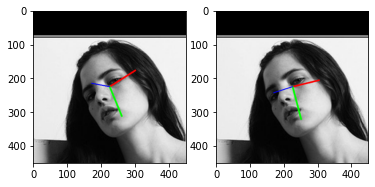

In [35]:
# image='./AFLW2000/image00133.jpg'
# mat = './AFLW2000/image00133.mat'

image='./AFLW2000/image00099.jpg'
mat = './AFLW2000/image00099.mat'

# image='./AFLW2000/image00374.jpg'
# mat = './AFLW2000/image00374.mat'

# image='./AFLW2000/image00376.jpg'
# mat = './AFLW2000/image00376.mat'

land_marks = face_land_marks(image)
land_marks = pd.DataFrame(np.array(land_marks).reshape(1,-1))
# print(land_marks)
SHI = Show_img_with_axis(image,mat,prediction=True,land_marks = land_marks)
# land_marks

### save model

In [36]:
filename = 'finalized_model_v6.sav'
joblib.dump(model, filename)

['finalized_model_v6.sav']